### A Brief History
The field of elliptic&ndash;curve mathematics predates its applications in public&ndash;key cryptography by some 1,800 years. But in 1985, mathematician Neal Koblitz (and, independently, Victor S. Miller) dragged it from the depths of theoretical obscurity into the practical realm.

In a paper titled [_Elliptic Curve Cryptosystems_](https://www.ams.org/journals/mcom/1987-48-177/S0025-5718-1987-0866109-5/S0025-5718-1987-0866109-5.pdf), Koblitz suggested that elliptic curves over finite fields were analogous&mdash;and perhaps even superior&mdash;to existing, practical implementations of public&ndash;key cryptography; in particular, those based on the multiplicative groups conceived by Whitfield Diffie and Martin Hellman in their seminal 1976 paper [_New Directions in Cryptography_](https://ee.stanford.edu/~hellman/publications/24.pdf), and later cleverly adapted to schemes such as public&ndash;key encryption and digital signature by [Taher Elgamal](https://en.wikipedia.org/wiki/Taher_Elgamal).

The efficacy of Diffie&ndash;Hellman style key agreement protocols relied on the difficulty of solving a one&ndash;way function known as the _discrete logarithm problem_, or _DLP_. With the contributions of Koblitz and Miller, elliptic&ndash;curve implementations of the DLP (known as _ECDLP_) have largely overtaken their multiplicative&ndash;group brethren due to their superior performance and security characteristics.

### An Elliptic Curve Over the Real Numbers
They say a picture is worth a thousand words. So it is very helpful to see what at an ellipctic curve actually looks like before discussing its use in cryptography. Using Python, we can plot such a curve over the real numbers.

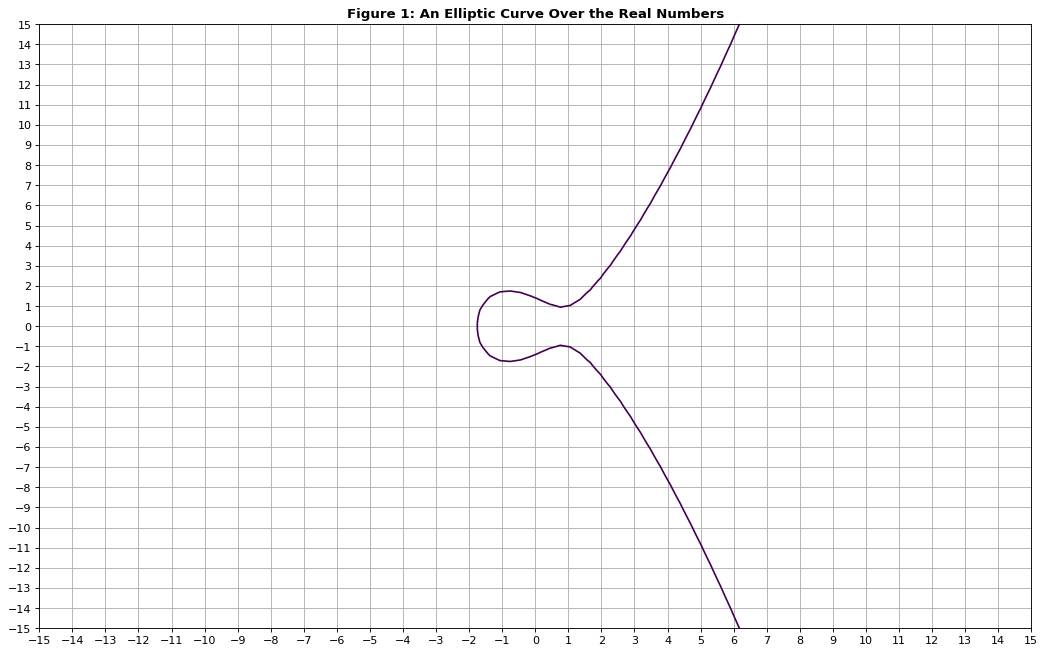

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(16,10), dpi=80)
def grid(start, stop):
    ticks = [_ for _ in range(start, stop)]
    plt.xticks(ticks)
    plt.yticks(ticks)

grid(-17,17)

y, x = np.ogrid[-15:15:100j, -15:15:100j]
a, b = -2, 2
plt.contour(x.ravel(), y.ravel(), pow(x, 3) - pow(y, 2) + a*x + b, [0])

plt.title("Figure 1: An Elliptic Curve Over the Real Numbers", fontsize="large", fontweight="bold")
plt.grid()
plt.show()

The elliptic curves used in public&ndash;key cryptography are over finite fields, which are confined to the integers (i.e., numbers without fractional components). But graphing curves over finite fields is not particularly compelling visually.

Graphing elliptic curves over the real numbers (i.e., numbers _with_ fractional components), however, gives us an excellent mental model for understanding their use in ellipctic curve cryptography.

Algebraically, the curve in _Figure 1_ is defined by the equation $y^2 = x^3 + ax + b$, where $x$ and $y$ are coordinate pairs that define the curve, and $a$ and $b$ are constant coeffients that influence its shape (in the curve in _Figure 1_, $a = -2$ and $b = 2$).

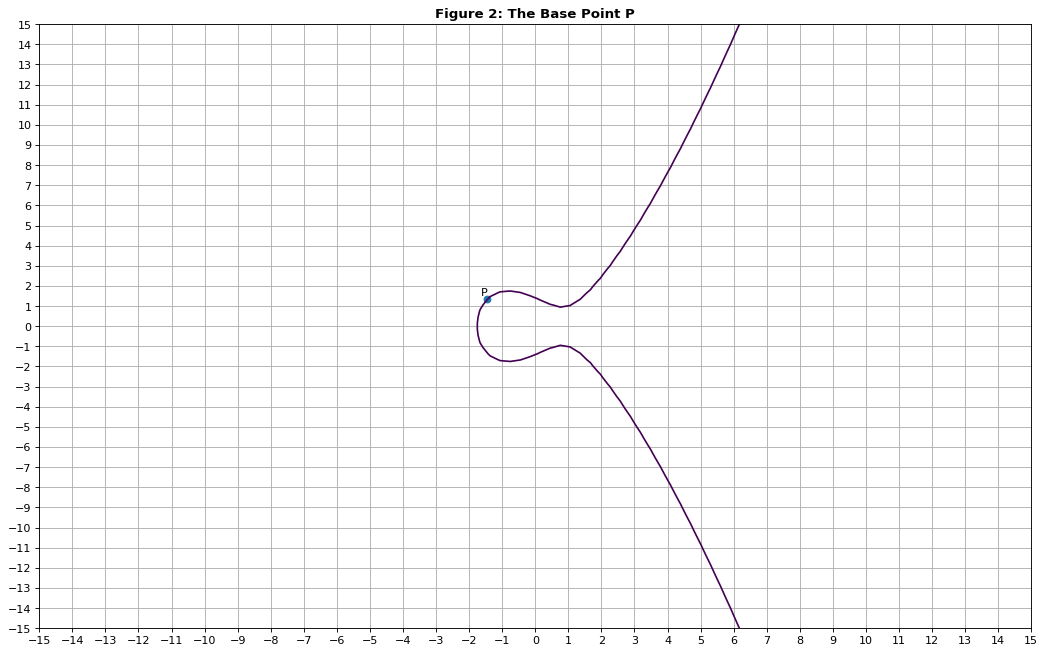

In [2]:
plt.figure(figsize=(16,10), dpi=80)
grid(-17,17)

plt.contour(x.ravel(), y.ravel(), pow(x, 3) - pow(y, 2) + a*x + b, [0])

Px, Py = -1.45221053, 1.33333333
plt.scatter(Px, Py)
plt.annotate("P", [Px-.2, Py+.2])

plt.title("Figure 2: The Base Point P", fontsize="large", fontweight="bold")
plt.grid()
plt.show()

### The Base Point
In _Figure 2_ we plot a single point $P$ on the curve at the coordinates ($x = -1.45$, $y = 1.33$). Let's call $P$ the _base_, or _generator_, point.

You may recall that multiplicative groups also have generators (also known as a _primitive elements_). These generators are the elements in the group that, when raised to consecutive powers, generate every other element in the group. The base point on an elliptic curve is analagous to the generator in a multiplicative group.

### Point Addition
It is possible to _add_ two points on an elliptic curve. The result, or _sum_, of this addition is a third point on the curve.

To add two distinct points $P$ and $Q$ on a curve, you draw a straight line between them. This line will (almost) always intersect the curve at a third point (the exception is where the $x$ coordinates of $P$ and $Q$ are the same). This 3<sup>rd</sup> point of intersection is called $-R$, which is the _additive inverse_ of $P + Q$. To find the sum, you draw a vertical line through $-R$, and the point where this line intersects the curve is called $R$, which gives us $P + Q = R$.

If this seems confusing, it is; but _Figure 3_ below should make it more clear.

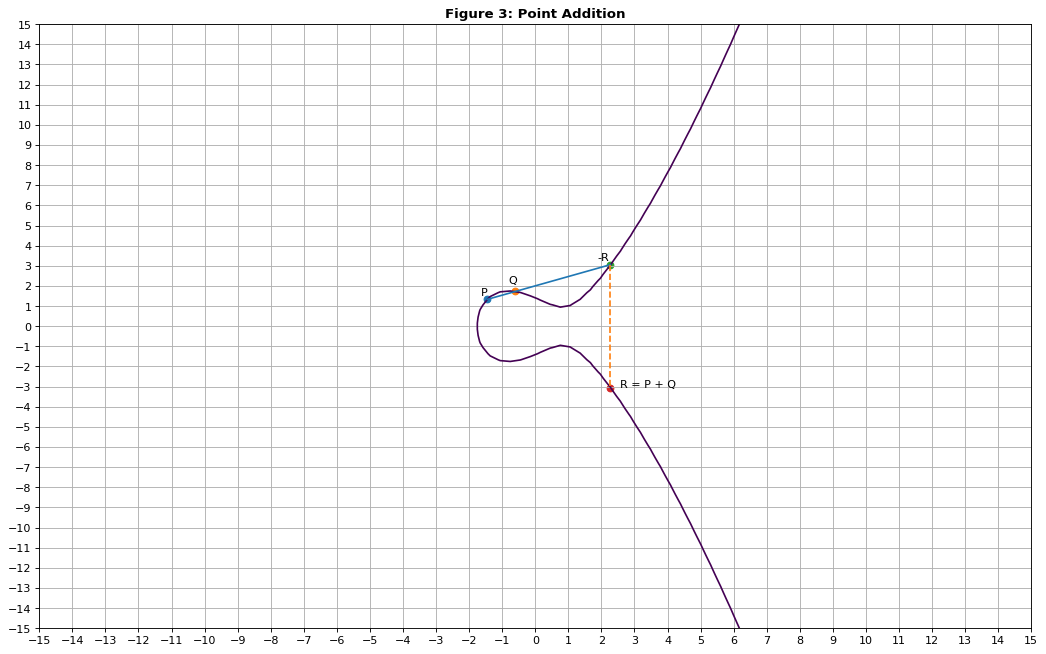

In [3]:
plt.figure(figsize=(16,10), dpi=80)
grid(-17,17)

plt.contour(x.ravel(), y.ravel(), pow(x, 3) - pow(y, 2) + a*x + b, [0])

plt.scatter(Px, Py)
plt.annotate("P", [Px-.2, Py+.2])

Qx, Qy = -.60606061, 1.72499344

plt.scatter(Qx, Qy)
plt.annotate("Q", [Qx-.2, Qy+.4])

def add(x1, y1, x2, y2):
    m = (y2 - y1) / (x2 - x1)
    x3 = pow(m, 2) - x1 - x2
    y3 = m * (x3 - x1) + y1
    return x3, -y3

Rx, Ry = add(Px, Py, Qx, Qy)

plt.scatter(Rx, -Ry)
plt.annotate("-R", [Rx-.4, -Ry+.2])
plt.plot([Px,Qx,Rx], [Py,Qy,-Ry])

plt.scatter(Rx, Ry)
plt.annotate("R = P + Q", [Rx+.3, Ry])
plt.plot([Rx, Rx], [-Ry, Ry], linestyle="--")

plt.title("Figure 3: Point Addition", fontsize="large", fontweight="bold")
plt.grid()
plt.show()

In _Figure 3_, the point $R$ is the sum of the points $P$ and $Q$ on the elliptic curve (and $-R$ is the additive inverse of $R$).

### The Mathematics Behind the _add()_ Function
The code that renders the addition of $P$ and $Q$ graphically in _Figure 3_ uses the complicated&ndash;looking `add()` function to do the work of summing the points. Let's take a look at each line of code in that function to see what is going on.

Given two points, where $P$ is defined by the coordinates $(x_1, y_1)$ and $Q$ is defined by the coordinates $(x_2, y_2)$, the equation for the slope of a straight line drawn between them is the following:

$\displaystyle \frac{y_2 - y_1}{x_2 - x_1}$

And this maps precisely to the first line code in the `add()` function.

`m = (y2 - y1) / (x2 - x1)`

The slope is assigned to the variable $m$, because we will need this value in subsequent computations.

Recall from above that the equation for an elliptic curve is $y^2 = x^3 + ax + b$. And recall from high school algebra that the equation for a straight line is $y = mx + B$, where $m$ is the slope of the line, and $B$ is the $y$&ndash;coordinate of the point at which the line intercepts the $y$ axis. Thus we can rewrite the curve equation as follows, substituting $mx + B$ for $y$:

$(mx + B)^2 = x^3 + ax + b$

Having reduced the curve equation to a _univariate_ (i.e., single variable) equation, we can manipulate it algebraically into the following form, which we call a _cubic_ polynomial equation:

$x^3 - m^2x^2 + (a - 2mB)x + (b - B^2) = 0$

(Incidentally, a cubic polynomial in which the coefficient of the first term is $1$ is also known as a _monic_ polynomial.)

Because the line between $P$ and $Q$ (almost always) intersects the curve at a third point $-R$, it has three distinct roots; that is, values of $x$ where the line intersects the curve at $P$, $Q$ and $-R$. Moreover, a property of cubic polynomials is that the sum of their roots is equal to the negative of the division of the coefficient of the second term by the coefficient of the first term. Algebraically:

$x_1 + x_2 + x_3 = -(\displaystyle \frac{-m^2}{1})$

Since the negative of a negative is a positive, and any number $n$ divided by $1$ equals $n$, we can simplify this to the following:

$x_1 + x_2 + x_3 = m^2$

Why is all this necessary? Because it gives us a way to determine the value of the third root, which is the $x$&ndash;coordinate of the third point of intersection $-R$ on the curve, or $x_3$. Rearranging the terms in the previous equation, we can compute $x_3$ as follows:

$x_3 = m^2 - x_1 - x_2$

The equation above thus maps to line 2 of the `add()` function:

`x3 = pow(m, 2) - x1 - x2`

All that is left now is to compute the $y$&ndash;coordinate of point $R$, or $y_3$. Here again, we employ the familiar straight-line equation, plugging $y_3$ and $x_3$ into it:

$y_3 = mx_3 + B$

Since we already know the values of $x_1$ and $y_1$, we can substitute $y_1 - mx_1$ (or $y_2 - mx_2$ for that matter) for $B$ to get the following equation:

$y_3 = mx_3 + (y_1 - mx_1)$

Simplifying the equation further, we get:

$y_3 = m(x_3 - x_1) + y_1$

And now we have an equation that maps to line 3 `add()` function:

`y3 = m * (x3 - x1) + y1`

With these three lines of code, we have thus solved for the coordinates $(x_3, y_3)$, or the point $-R$, in the graph in _Figure 3_.

Finally, recall that the sum of $P$ and $Q$ is in fact the additive inverse of the third point of intersection on the curve, or $-R$. To produce $R$, we simply reverse the sign of $y_3$, and return $(x_3, -y_3)$ from the `add()` function:

`return x3, -y3`

### Point Doubling
So far, we've added two _distinct_ points $P$ and $Q$ to get a third point $R$. But in a cryptographic implementation, we are given just a single starting point; the base point $P$.

To generate a second point (and all subsequent points on the curve) from a single base point, we add the base point to _itself_, as in $P + P$. This is done by drawing a straight line where the base point $P$ is _tangent_ to the curve, and finding the second point of intersection, just like we did when we added $P + Q$ to find the third point of intersection.

Another way of saying that we are adding a point to itself is that we are _doubling_ a point, as in $2P = P + P$.

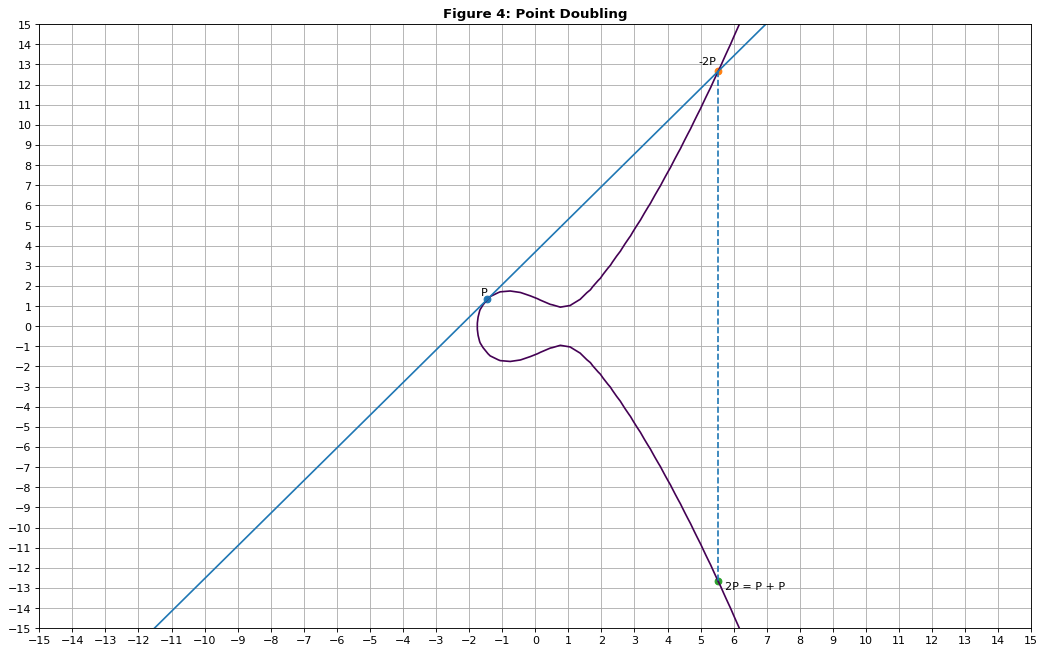

In [4]:
plt.figure(figsize=(16,10), dpi=80)
grid(-17,17)

plt.contour(x.ravel(), y.ravel(), pow(x, 3) - pow(y, 2) + a*x + b, [0])

plt.scatter(Px, Py)
plt.annotate("P", [Px-.2, Py+.2])

def double(x1, y1, a):
    m = ((3 * pow(x1, 2)) + a) / (2 * y1)
    x2 = pow(m, 2) - 2 * x1
    y2 = m * (x2 - x1) + y1
    return x2, -y2

P2x, P2y = double(Px, Py, a)

plt.scatter(P2x, -P2y)
plt.annotate("-2P", [P2x-.6, -P2y+.3])
plt.axline(xy1=(Px,Py), xy2=(P2x,-P2y))

plt.scatter(P2x, P2y)
plt.annotate("2P = P + P", [P2x+.2, P2y-.4])
plt.plot([P2x,P2x], [-P2y,P2y], linestyle="--")

plt.title("Figure 4: Point Doubling", fontsize="large", fontweight="bold")
plt.grid()
plt.show()

In _Figure 4_, we've added $P$ to itself, or doubled $P$. Again, to double the base point $P$ (or any point for that matter), you draw a line tangent to the curve at $P$, find the point of intersection with the curve $-2P$, and take its additive inverse to get $2P$.

### The Mathematics Behind the _double()_ Function
The code in the `double()` function is very similar to that in the `add()` function, which was described in detail in the previous section. There are some differences, however, owing to the fact that we are adding a point to itself rather than adding two distinct points.

As with the `add()` function, in the `double()` function we must first find the slope of the line passing through $P$, where $P$ is defined by the coordinates $(x_1, y_1)$. Recall that the line passing through $P$ is the line tangent to $P$. To find the slope of the line tangent to $P$, we apply the rules of differentiation to both sides of the curve equation $y^2 = x^3 + ax + b$:

$2y_1 \displaystyle \frac{dy}{dx} = 3x_1^2 + a$

Solving this equation for the tangent (or _derivative_), we get:

$\displaystyle \frac{dy}{dx} = \frac{3x_1^2 + a}{2y_1}$

This gives us line 1 of the `double()` function:

`m = ((3 * pow(x1, 2)) + a) / (2 * y1)`

To find $x_2$, or the $x$&ndash;coordinate of $2P$ on the curve, we employ the same rules of cubic polynomials we used in the `add()` function. Recall from the previous section that $m^2$ is the negative of the coefficient of the second&ndash;highest power of $x$ (i.e., the second term) in the curve equation, and that the sum of its roots are equal to that value. In this case, however, the first two roots are $x_1$.

$x_1 + x_1 + x_2 = m^2$

Isolating $x_2$ in this equation gives us the following:

$x_2 = m^2 - 2x_1$

And this maps to line 2 of the `double()` function:

`x2 = pow(m, 2) - 2 * x1`

As for the $y$&ndash;coordinate of $2P$, or $y_2$, we again employ the equation for a straight line (i.e., $y = mx + B$), just like we did in the `add()` function:

$y_2 = mx_2 + B$

Substituting $y_1 - mx_1$ for $B$ in this equation gives us:

$y_2 = mx_2 + (y_1 - mx_1)$

Simplifying the above, we get:

$y_2 = m(x_2 - x_1) + y_1$

And now we have line 3 of the `double()` function:

`y2 = m * (x2 - x1) + y1`

Finally, having solved for $(x_2, y_2)$, or $-2P$, we must return its additive inverse, or $2P$, from the `double()` function. Again, we do this by reversing the sign of $y2$ to get $(x_2, -y_2)$.

`return x2, -y2`

Let's continue with another example, this time computing the sum $P + 2P$, which results in $3P$.

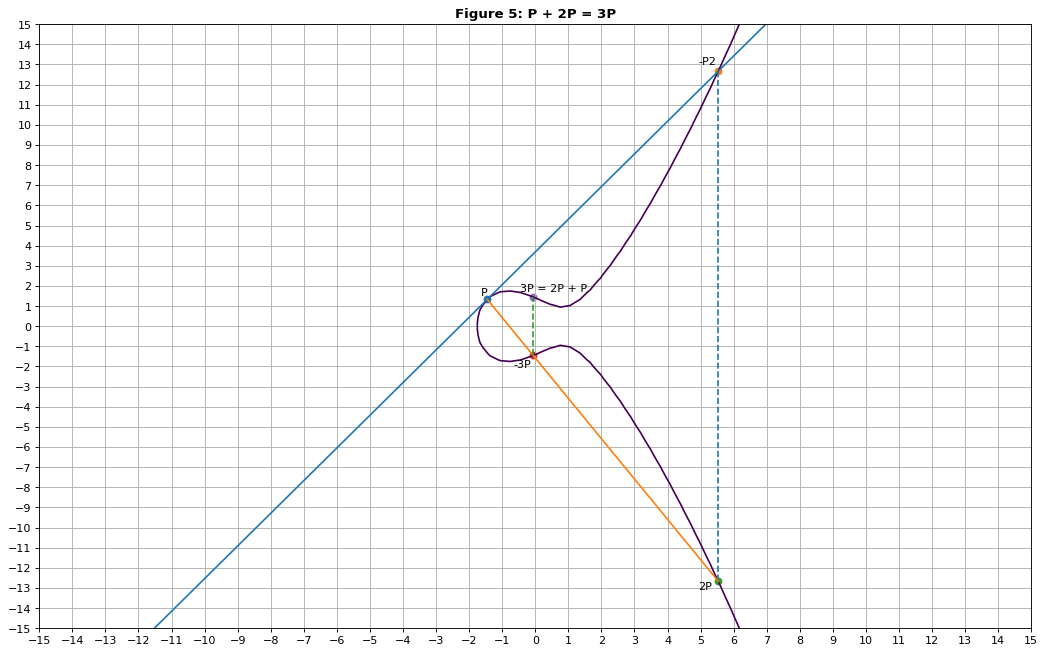

In [5]:
plt.figure(figsize=(16,10), dpi=80)
grid(-17,17)

plt.contour(x.ravel(), y.ravel(), pow(x, 3) - pow(y, 2) + a*x + b, [0])

plt.scatter(Px, Py)
plt.annotate("P", [Px-.2, Py+.2])

plt.scatter(P2x, -P2y)
plt.annotate("-P2", [P2x-.6, -P2y+.3])
plt.axline(xy1=(Px,Py), xy2=(P2x,-P2y))

plt.scatter(P2x, P2y)
plt.annotate("2P", [P2x-.6, P2y-.4])
plt.plot([P2x,P2x], [-P2y,P2y], linestyle="--")

P3x, P3y = add(Px, Py, P2x, P2y)

plt.scatter(P3x, -P3y)
plt.annotate("-3P", [P3x-.6, -P3y-.6])
plt.plot([Px,P2x], [Py,P2y])

plt.scatter(P3x, P3y)
plt.annotate("3P = 2P + P", [P3x-.4, P3y+.3])
plt.plot([P3x,P3x], [-P3y,P3y], linestyle="--")

plt.title("Figure 5: P + 2P = 3P", fontsize="large", fontweight="bold")
plt.grid()
plt.show()

In _Figure 5_, we've used the same technique to add $P$ and $2P$ that we used to add $P$ and $Q$ in _Figure 3_; that is, we drew a straight line between $P$ and $2P$, found the point of intersection with the curve $-3P$, and took its $y$&ndash;axis reflection $3P$ as the sum of the addition.

Having established the procedures for adding and doubling points on an elliptic curve, we now have the tools to implement a one&ndash;way function that allows us to use the elliptic curve in a cryptographic scheme.

### The Elliptic Curve Discrete Logarithm Problem
The discrete logarithm problem, as conceived by Diffie and Hellman, boils down to the difficulty of determining the value of an exponent given just its base, and the result of the exponent's application to this base. Algebraically, this translates to the question, given $x$ and $z$ in the equation $x^y = z$, what is the value of $y$? (Actually, in the realm of multiplicative groups, this should in fact be the congruence relation $x^y \equiv z \pmod p$; but, to keep things simple, we'll just say it's an equation.)

Another way of asking this question is, how many times must $x$ be multiplied to itself to produce $z$? It turns out this equation is very easy to compute in the _forward_ direction&mdash;that is, given $x$ and $y$, it is very easy to determine the value of $z$&mdash;but very hard to compute in the _reverse_ direction. This is why the DLP is referred to as a _one&ndash;way function_.

With elliptic curves we can pose an analogous question: Given a point $Q$, how many times must you add the base point $P$ to itself to reach $Q$? Algebraically, this translates to the question, given $P$ and $Q$ in the equation $d \times P = Q$, what is the value of $d$, where $d$ is the number of repeated additions of $P$? While it is very easy to compute $Q$ given $d$ and $P$, it turns out to be very difficult to compute $d$ given $P$ and $Q$.

In a cryptographic scheme, $d$ can be thought of as the private key, and $Q$ the public key. And whereas it is very easy for a user (say, Alice) to generate an elliptic&ndash;curve key pair $d$ and $Q$, publish $Q$ widely, and participate in a secure key exchange with another user (say, Bob), it is very difficult for an eavesdropper (say, Eve) to recover $d$ from the public parameters $P$ and $Q$.

The discerning reader may now wonder, why is it any more difficult for our adversary, Eve, to compute the private key $d$, given $P$ and $Q$, than it is for Alice to compute $Q$ given $d$ and $P$? After all, Alice must perform $d$ additions of $P$ to compute $Q$, which is exactly the same number of additions Eve must perform to find $Q$ (thereby revealing the value of the private key $d$ to Eve).

### Double&ndash;and&ndash;Add
It turns out we've already seen the answer, and it has to do with point doubling. Because Alice knows the value of $d$ in advance, she enjoys a crucial advantage over Eve.

Let's say Alice has selected $d$ using a cryptographically secure pseudo&ndash;random number generator (CSPRNG); note that $d$ is selected from the interval $1 < d < n$, where $n$ is the the _order_ of the curve's base point. If Alice is using a cryptographically secure curve, this means that $d$ will be an astronomically large number and, moreover, because it was generated by a CSPRNG, all but impossible for Eve to guess.

Alice's advantage is that her advance knowledge of $d$ allows her to use a shortcut to compute $Q$ that Eve cannot use. She does this by scanning the binary representation of $d$, starting with the most significant bit; i.e., she scans the bits from left to right. The first bit she sees will always be `1`, and this represents the base point $P$. For every bit she encounters thereafter, whether it is a `0` or a `1`, she doubles the current point. However, if she encounters a `1` bit, in addition to doubling the current point, she also _adds_ to it the base point.

For example, say $d = 26$, the binary representation of which is `11010`. Whereas Eve must perform 26 operations (specifically, point additions) to find $Q$, Alice must perform only 6 (point additions _and_ doublings).

| Bit | Operation    | Computation     | Result
|-----|--------------|-----------------|-------
| `1` | base point   | None            | $P$
| `1` | double & add | $(P + P ) + P$  | $3P$
| `0` | double       | $(3P + 3P)$     | $6P$
| `1` | double & add | $(6P + 6P) + P$ | $13P$
| `0` | double       | $(13P + 13P)$   | $26P$

This _double&ndash;and&ndash;add_ algorithm allows Alice to compute $Q$ in logarithmic time. Being stuck with point additions only, however, Eve's task requires linear time. If $d$ is big enough, linear time won't cut it, and Eve won't even bother trying.

We can demonstrate the advantage of repeated point&ndash;doubling graphically in _Figure 6_.

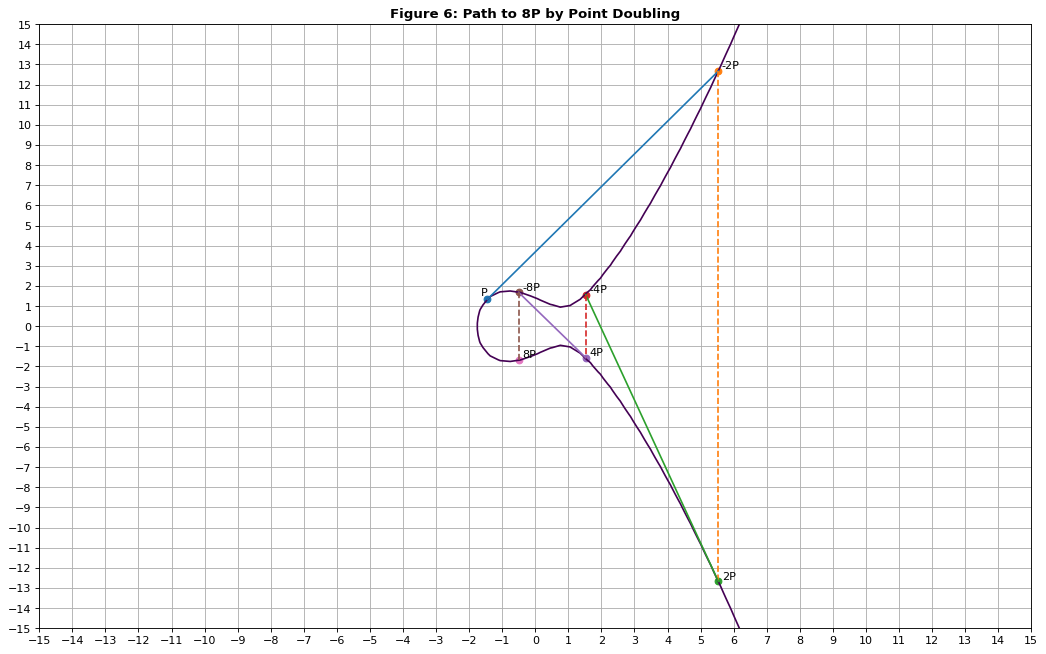

In [6]:
plt.figure(figsize=(16,10), dpi=80)
grid(-17,17)

plt.contour(x.ravel(), y.ravel(), pow(x, 3) - pow(y, 2) + a*x + b, [0])

plt.scatter(Px, Py)
plt.annotate("P", [Px-.2, Py+.2])

xs, ys = [Px], [Py]
X, Y = Px, Py
for i in range(1,4):
    X, Y = double(X, Y, a)

    plt.scatter(X, -Y)
    plt.annotate(f"{-(1<<i)}P", [X+.1, -Y+.1])
    xs.append(X)
    ys.append(-Y)
    plt.plot(xs, ys)
    xs = xs[1:]
    ys = ys[1:]

    plt.scatter(X, Y)
    plt.annotate(f"{1<<i}P", [X+.1, Y+.1])
    xs.append(X)
    ys.append(Y)
    plt.plot(xs, ys, linestyle="--")
    xs = xs[1:]
    ys = ys[1:]

plt.title("Figure 6: Path to 8P by Point Doubling", fontsize="large", fontweight="bold")
plt.grid()
plt.show()

In _Figure 6_, it took $log_2 8$, or $3$, steps to find the point at $8P$; specifically, we used $3$ doubling operations to arrive at $8P$.

In _Figure 7_, let's compute $8P$ using just point addition (note that since we are starting with only a single base point, we must use point doubling on the first iteration of the loop).

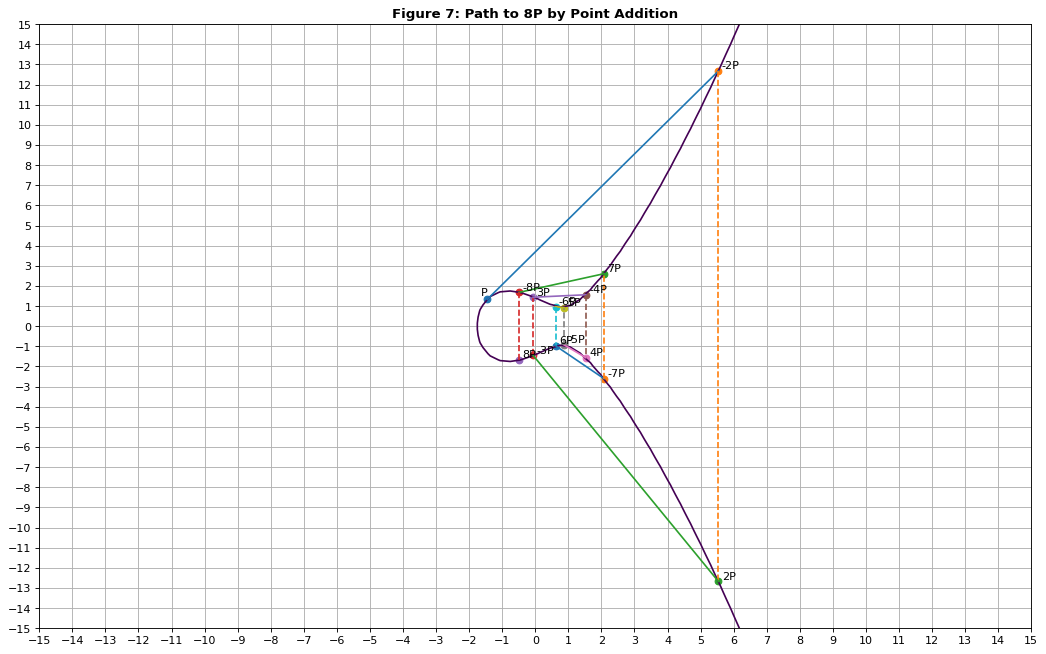

In [7]:
plt.figure(figsize=(16,10), dpi=80)
grid(-17,17)

plt.contour(x.ravel(), y.ravel(), pow(x, 3) - pow(y, 2) + a*x + b, [0])

plt.scatter(Px, Py)
plt.annotate("P", [Px-.2, Py+.2])

xs, ys = [Px], [Py]
X, Y = Px, Py
for i in range(1,8):
    if i == 1:
        X, Y = double(X, Y, a)
    else:
        X, Y = add(Px, Py, X, Y)

    plt.scatter(X, -Y)
    plt.annotate(f"{-(i+1)}P", [X+.1, -Y+.1])
    xs.append(X)
    ys.append(-Y)
    plt.plot(xs, ys)
    xs = xs[1:]
    ys = ys[1:]

    plt.scatter(X, Y)
    plt.annotate(f"{i+1}P", [X+.1, Y+.1])
    xs.append(X)
    ys.append(Y)
    plt.plot(xs, ys, linestyle="--")
    xs = xs[1:]
    ys = ys[1:]

plt.title("Figure 7: Path to 8P by Point Addition", fontsize="large", fontweight="bold")
plt.grid()
plt.show()

In _Figure 7_, we've arrived at the same point $8P$ using point addition that we did using point&ndash;doubling in _Figure 6_; but using point addition it took us $5$ more steps to get there.

Of course, for this trivially small value of $d$, the time savings of $5$ steps is negligible. As the size of $d$ increases, however, this savings grows exponentially. And, as we now know, in a real&ndash;world implementation $d$ will be an unfathomably large number.

### Elliptic Curves Over Finite Fields
We have thus far only examined elliptic curves over the real numbers, but the elliptic curves used in cryptography are plotted over finite fields. Let's see what the latter looks like geometrically, compared to the real number&ndash;based curves we plotted above.

To plot such a curve, I will employ the services of this repository's [ec](https://github.com/dchampion/crypto/blob/master/src/core/ec.py) module, which implements many of the elliptic curve primitives we have already discussed.

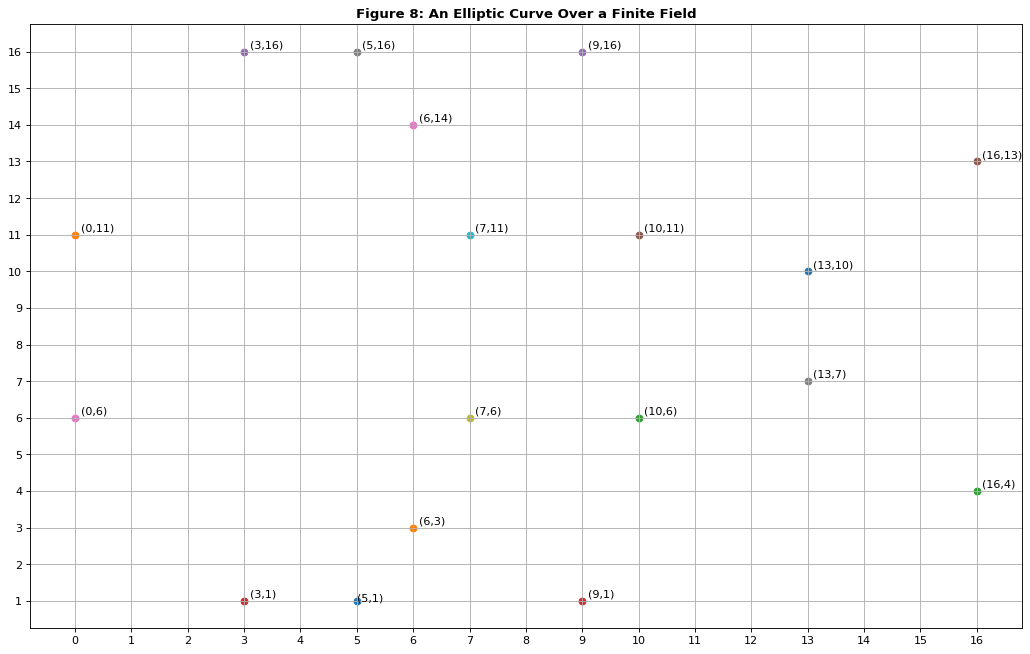

In [8]:
import os
os.chdir("../src")

from core import curves
from core import ec

plt.figure(figsize=(16,10), dpi=80)
grid(0,17)

# Using "ec" module to construct an elliptic curve over a finite field.
ec.new_curve(curves.Curve(p=17,a=2,b=2,Gx=5,Gy=1,n=19,h=1), B_iters=5)

pt = ec.base_point()
plt.scatter(pt.x, pt.y)
plt.annotate(f"({pt.x},{pt.y})", [pt.x, pt.y])

while pt != ec.id_elem():
    pt += ec.base_point()
    plt.scatter(pt.x, pt.y)
    if pt != ec.id_elem():
        plt.annotate(f"({pt.x},{pt.y})", [pt.x+.1, pt.y+.1])

plt.title("Figure 8: An Elliptic Curve Over a Finite Field", fontsize="large", fontweight="bold")
plt.grid()
plt.show()

The most obvious thing to note about _Figure 8_ is that there's no _curve_ there, at least not in the geometric sense we saw in the previous figures, which plotted a curve over the real numbers.

Algebraically, however, this is still very much an elliptic curve. Recall that the equation for an elliptic curve over the real numbers is $y^2 = x^3 + ax + b$. But, for an elliptic curve over a finite field, the equation is $y^2 \equiv x^3 + ax + b \pmod p$ (the triple bar $\equiv$ denotes a _congruence relation_, which simply means all terms in the equation are taken modulo $p$).

Not surprisingly, $p$ is a prime number. Taking results modulo $p$ confines our curve points to a finite field or, more specifically, a cyclic group. In the curve in _Figure 8_, that group consists of just $19$ points. This number (let's call it $n$) is referred to as the _order_ of the curve, and it too is a prime number. Note that for a curve to be cryptographically secure, its order must be very large (an integer in the range of 77 decimal digits in length). We've defined a much smaller (and therefore much less secure) curve here, in order to demonstrate its properties without getting distracted by huge numbers.

### Dissecting the Elliptic Curve
Let's take a closer look at this curve. First, recall that an elliptic curve over a finite field is defined by the congruence relation $y^2 \equiv x^3 + ax + b \pmod p$. In this relation, $x$ and $y$ represent coordinates on a cartesian plane, $a$ and $b$ constant coefficients, and $p$ a prime modulus that confines results to a finite integral field.

To flesh out the curve equation above, we supplied the following domain parameters to the `Curve` object, which is the first parameter we passed to the `new_curve()` function of the `ec` module:

- A field parameter $p$ ($17$) (this is the prime modulus)
- A coefficient $a$ ($2$)
- A coefficient $b$ ($2$)
- An $x$&ndash;coordinate for the base point $G$ ($5$)
- A $y$&ndash;coordinate for the base point $G$ ($1$)
- The order $n$ of the base point $G$ ($19$)
- The cofactor $h$ of the curve point group, which is the total number of points on the curve divided by the order of $G$, or $n$ ($1$)

We also supplied a second, optional parameter to the `new_curve()` function (`B_iters=5`). This parameter specifies the number of iterations to test the curve's strength against a certain class of attacks ($5$ is the value we supplied because the default&mdash;$100$&mdash;will cause this small curve to fail validation).

If any of these parameters is invalid, the function `new_curve()` will raise an exception. As it turns out, a curve with these parameters is perfectly valid (albeit wholly insecure due to its small size).

Let's have a look at our curve's domain parameters, which should match those enumerated in the bulleted list above.

In [9]:
print(ec._CURVE)

Curve curve parameters:
 p:  17
 a:  2
 b:  2
 Gx: 5
 Gy: 1
 n:  19
 h:  1


Using point addition, we can see all our curve's points.

In [10]:
print(ec.base_point())
next_pt = ec.base_point()
while next_pt != ec.id_elem():
    next_pt += ec.base_point()
    print(next_pt)

x=5, y=1
x=6, y=3
x=10, y=6
x=3, y=1
x=9, y=16
x=16, y=13
x=0, y=6
x=13, y=7
x=7, y=6
x=7, y=11
x=13, y=10
x=0, y=11
x=16, y=4
x=9, y=1
x=3, y=16
x=10, y=11
x=6, y=14
x=5, y=16
x=None, y=None


Note that the first point in the list, the base point ($x=5$, $y=1$), comes from the parameters $Gx$ and $Gy$. Also note that the last point is ($x=None$, $y=None$), which in an elliptic&ndash;curve point group is the identity element (this is also known as _the point at infinity_).

The total number of points in the curve group is $19$, which we see reflected in the parameter $n$ (this can be verified by counting the coordinate pairs in the list above).

With our elliptic curve thus defined, let's use it in a cryptographic scheme that allows two parties to negotiate a shared secret (say, for example, a session key they can use to encrypt messages in a symmetric cipher).

We start by computing a keypair, which we call `keypair_a` to denote that it belongs to party `a` (let's call her Alice).

In [11]:
# Alice computes her keypair
keypair_a = ec.make_key()
print(keypair_a)

d=9, Q=[x=7, y=6]


Note that Alice's private key $d$ represents the $1$&ndash;based index of the curve in the list we printed above; that is, it is the $d$<sup>th</sup> point in the list.

Specifically, to generate the keypair, the function `ec.make_key()` added $d$ points to the base point ($x=5$, $y=1$) to arrive at the point represented by Alice's public key $Q$ (the private key $d$, incidentally, was selected randomly from the range $1 < d < n-1$).

Next, let's compute a second keypair. This one we'll call `keypair_b` to denote that it belongs to Bob, the other participant in our simulated key negotiation.

In [12]:
# Bob computes his keypair
keypair_b = ec.make_key()
print(keypair_b)

d=9, Q=[x=7, y=6]


For Alice and Bob to negotiate a secret key, they will employ the Diffie&ndash;Hellman (DH) technique. But instead of using a multiplicative integer group in the manner specified in classic DH, they will instead use our elliptic curve point group.

Alice starts the procedure by retrieving her public key from her keypair. She stores it in `pub_key_a`, and transmits this to Bob over an insecure channel where it is observed by an adversary.

Note that if we inspect Alice's public key `pub_key_a`, we see that the private key $d$ is not contained in it. Indeed, Alice must not transmit her private key to Bob&mdash;or reveal it to anyone in any other manner, for that matter&mdash;lest it be used by the adversary to decrypt Alice's and Bob's messages.

In [13]:
# Alice retrieves her public key and transmits it to Bob
pub_key_a = keypair_a.public_key()
print(pub_key_a)

x=7, y=6


Bob continues the procedure by extracting the public key (`pub_key_b`) from his keypair, and transmits it to Alice over the insecure channel.

Note that Bob's public key is not the same as Alice's (although in a curve with just $19$ points, such a coincidence is not infeasible).

In [14]:
# Bob retrieves his public key and transmits it to Alice
pub_key_b = keypair_b.public_key()
print(pub_key_b)

x=7, y=6


Next, using the public key she received from Bob, Alice computes a secret key and stores it in `session_key_a`.

In [15]:
# Alice computes a shared secret using Bob's public key
session_key_a = keypair_a.make_session_key(pub_key_b)

Bob likewise computes a secret key, using Alice's public key, and stores it in `session_key_b`.

In [16]:
# Bob computes a shared secret using Alice's public key
session_key_b = keypair_b.make_session_key(pub_key_a)

If the essential property of DH holds, Alice's and Bob's shared secrets&mdash;`session_key_a` and `session_key_b`&mdash;should be identical.

Further, the adversary eavesdropping on the insecure channel, having only observed Alice's and Bob's public keys, cannot feasibly derive the shared secret with just that knowledge. The only way for the adversary to find the secret is to add curve points repeatedly, starting with the base point, until she finds the secret. With a standard ECC key length of $256$ bits, this would require something on the order of $2^{128}$ trial point additions, a process that at current computer speeds would take many millenia (of course in the present example, using a curve with just $19$ points, it would take at most that many steps to find the shared secret).

Here we confirm that `session_key_a` is in fact equivalent to `session_key_b`.

In [17]:
session_key_a == session_key_b

True

Alice and Bob are now ready to encrypt and decrypt messages to one another, using this shared secret, over the insecure channel. Further, they can be confident that an adversary who intercepts the messages won't be able to decrypt them.

If you are familiar with traditional Diffie&ndash;Hellman, you will have recognized a pattern here. The essential property of DH is expressed in the signature of the method `make_session_key()`; namely, a shared secret is computed using one party's private key in combination with the other party's public key (in the present case these are Alice's private key $d$&mdash;which is hidden inside her keypair `keypair_a`&mdash;and Bob's public key `pub_key_b`).

Whereas in traditional DH the public key is raised to the power of the private key (both integers), in Elliptic Curve DH (ECDH) the private key (an integer) is multiplied by&mdash;or, rather, added repeatedly to&mdash;the public key (a curve point). The result of both operations is a shared secret; in the former this key is an integer, and in the latter it is a curve point.

One additional implementation detail is worth noting here: One might wonder how it is that a curve point $(x,y)$, generated by the multiplication of an integer to the base point, can be represented as a numeric key in a symmetric cipher. The answer is that just the $x$&ndash;coordinate of the public key&mdash;which itself is an integer in the range $0 < x < p$&mdash;is used as the session key.

### Final Observations
A few special properties of elliptic curves of prime order lend themselves to applications in cryptography.

First, note that the values of $p$ and $n$, while both prime, are not the same (in the example above $p=17$ and $n=19$). This is because curve points are not integers, but rather $xy$ coordinate pairs, each member of which can have a value from $0$ to $p-1$. This means there are $p^2 + 1$ possible distinct $xy$ pairs. Therefore, unlike the traditional implementation of the discrete logarithm problem given by Diffie&ndash;Hellman, the group order $n$ does not necessarily equal one less than the prime modulus $p$, or $p-1$.

Second, a very important [result from Hasse](https://en.wikipedia.org/wiki/Hasse%27s_theorem_on_elliptic_curves) tells us that, even if they are not equal, $p$ must nevertheless be very close to $n$. Specifically, $n$ must fall within the _Hasse bound_, which asserts the following:

$|n-(p+1)| <= 2\sqrt{p}$

In practical terms, this means that if the field parameter $p$ of an elliptic curve group is a very large number, so too is the group's order $n$. This is important, because when selecting a field parameter for an elliptic curve, cryptographers must know there are a sufficient number of points on the curve to make solving the discrete logarithm very hard.

Third, due to [Lagrange's theorem](https://en.wikipedia.org/wiki/Lagrange's_theorem_%28group_theory%29), since the order $n$ of the curve is prime, its only subgroups are $1$ and the subgroup of order $n$, or the group itself. As a consequence, every single point on the curve (except the artificial _point at infinity_, which serves as the group's identity element) will generate the entire group.

Finally, how do we know $n$ is prime? After all, Hasse only tells us the interval within which $n$ falls, not its precise value. This was made possible by [Schoof](https://en.wikipedia.org/wiki/Schoof%27s_algorithm), who in 1985 devised a polynomial&ndash;time algorithm to count the number of points on a curve.

With these properties, cryptographers have the ingredients required to create cryptographically secure curves.

Geometrically, elliptic curves over finite fields could not be more different from those over the real numbers. Algebraically, however, they behave almost exacly the same, and therefore provide a powerful implementation of the discrete logarithm problem suitable for use in cryptographic schemes.